In [92]:
# Package Imports
import maboss
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil


In [ ]:
# Helper and script imports
import sys
sys.path.append("/Users/emilieyu/endotehelial-masboss")
from boolean_models.scripts.run_wt_single import main
from boolean_models.analysis import (
    generate_ko_models,
    compute_delta,
    classify_phenotype,
    generate_ko_names,
    save_df_to_csv
)

from boolean_models.scripts.run_kos_single import extract_steady_state

In [ ]:
# Set project root dir
PROJECT_ROOT = Path("/Users/emilieyu/endotehelial-masboss/")
MODELS_DIR = PROJECT_ROOT / "boolean_models" / "models"
RESULTS_DIR = PROJECT_ROOT / "results" / "boolean_models" / "rho_test"/ "ko_single"

# load model and WT configuration
model_file = MODELS_DIR / "rho.bnd"
cfg_file   = MODELS_DIR / "rho_base.cfg"

model = maboss.load(str(model_file), str(cfg_file))
nodes = ['DSP', 'TJP1', 'JCAD']

raw_dir = RESULTS_DIR / "raw"
processed_dir = RESULTS_DIR / "processed"
ss_dir = RESULTS_DIR / "steady_state"

fig_time_dir = RESULTS_DIR / "figures_timecourse"
fig_ss_dir = RESULTS_DIR / "figures_steady_state"

# raw_dir.mkdir(parents=True, exist_ok=True)
# processed_dir.mkdir(parents=True, exist_ok=True)

fig_time_dir.mkdir(parents=True, exist_ok=True)
fig_ss_dir = RESULTS_DIR / "figures_timecourse"


### Reminder: Basic Perturbation Behaviour Validation

Generate perturbation scenarios, run perturbations, and store raw output

In [19]:
ko_scenarios = generate_ko_models(model, nodes)

In [8]:
def save_sim_details(result, result_directory, perb_name):
    # Save node probabilities
    nodes_probtraj = result.get_nodes_probtraj().rename_axis('t').reset_index()    
    nodes_probtraj.to_csv(
        result_directory / f"{perb_name}_nodes_probtraj.csv",
        index=False
    )

    # Save state probabilities
    states_probtraj = result.get_states_probtraj().rename_axis('t').reset_index()    
    states_probtraj.to_csv(
        result_directory / f"{perb_name}_states_probtraj.csv",
        index=False
    )


In [12]:
perb_dict = {}
phenotype_dict = {}

# Run simulations. 
for name, model in ko_scenarios.items():
    print(f"DEBUG: Running scenario: {name}")

    res_dir = RESULTS_DIR / "rho_model" / name
    
    # Ensure clean output directory
    if res_dir.exists():
        shutil.rmtree(res_dir)
    res_dir.mkdir(parents=True, exist_ok=True)

    # Run MaBoSS
    res = model.run()

    prob_df = res.get_nodes_probtraj()

    # Save raw simulation details
    save_sim_details(res, res_dir, name)
    
    # Compute Rho balance
    balance_df = prob_df.copy().rename_axis('t').reset_index()   
    balance_df["delta"] = compute_delta(balance_df)
    perb_dict[name] = balance_df

    # Compute raw phenotypes
    phenotype_df = classify_phenotype(balance_df).rename_axis('t').reset_index()   
    phenotype_dict[name] = phenotype_df

    # Compute raw phenotypes
    print(f"DEBUG: Writing intermediate data to file for: {name}")
    balance_df.to_csv(res_dir / f"{name}_phenotype.csv")
    phenotype_df.to_csv(res_dir / f"{name}_phenotype.csv")


DEBUG: Running scenario: WT
DEBUG: Writing intermediate data to file for: WT
DEBUG: Running scenario: DSP_ko
DEBUG: Writing intermediate data to file for: DSP_ko
DEBUG: Running scenario: TJP1_ko
DEBUG: Writing intermediate data to file for: TJP1_ko
DEBUG: Running scenario: JCAD_ko
DEBUG: Writing intermediate data to file for: JCAD_ko
DEBUG: Running scenario: DSP_TJP1_ko
DEBUG: Writing intermediate data to file for: DSP_TJP1_ko
DEBUG: Running scenario: DSP_JCAD_ko
DEBUG: Writing intermediate data to file for: DSP_JCAD_ko
DEBUG: Running scenario: TJP1_JCAD_ko
DEBUG: Writing intermediate data to file for: TJP1_JCAD_ko
DEBUG: Running scenario: DSP_TJP1_JCAD_ko
DEBUG: Writing intermediate data to file for: DSP_TJP1_JCAD_ko


In [15]:
tjp1 = perb_dict['TJP1_ko']
tjp1

,t,DSP,TJP1,JCAD,RhoA,RhoC,delta
0,0.0,0.494499,0.0,0.502700,0.540813,0.482015,-0.058798
1,0.1,0.494500,0.0,0.502700,0.582336,0.457086,-0.125250
2,0.2,0.494500,0.0,0.502700,0.604272,0.441025,-0.163247
3,0.3,0.494499,0.0,0.502700,0.618445,0.431285,-0.187160
4,0.4,0.494502,0.0,0.502701,0.631145,0.420570,-0.210575
5,0.5,0.494500,0.0,0.502699,0.635770,0.416423,-0.219347
6,0.6,0.494499,0.0,0.502699,0.641917,0.417531,-0.224386
7,0.7,0.494501,0.0,0.502700,0.647124,0.416122,-0.231002
8,0.8,0.494500,0.0,0.502700,0.653147,0.410364,-0.242783
9,0.9,0.494500,0.0,0.502699,0.657581,0.405227,-0.252354


### Refactoring

In [25]:
# Generate KO Perturbation
ko_scenarios = generate_ko_models(model, nodes)

# Dictionary storing node probability + delta trajectories
perb_dict = {}
phenotype_dict = {}

# Run simulations. 
for name, model in ko_scenarios.items():

    # Run MaBoSS
    res = model.run()

    # Basic sanity check
    prob_df = res.get_nodes_probtraj().rename_axis('t')
    save_df_to_csv(prob_df, raw_dir, f"{name}_nodes_probraj.csv")
    
    # Compute Rho balance
    balance_df = prob_df.copy()  
    balance_df["delta"] = compute_delta(balance_df)
    save_df_to_csv(balance_df, processed_dir, f"{name}_balance.csv")

    perb_dict[name] = balance_df

    # Compute raw phenotypes
    phenotype_df = classify_phenotype(balance_df, eps=0.20)  
    save_df_to_csv(phenotype_df, processed_dir, f"{name}_phenotype.csv")

    phenotype_dict[name] = phenotype_df


# Compute and save combined steady state data
balance_concat_df = extract_steady_state(perb_dict)
pheno_concat_df = extract_steady_state(phenotype_dict)

save_df_to_csv(balance_concat_df, processed_dir, f"steady_state_balance.csv")
save_df_to_csv(pheno_concat_df, processed_dir, f"steady_state_phenotype.csv")


DEBUG: File WT_nodes_probraj.csv successfully written to directory: /Users/emilieyu/endotehelial-masboss/results/boolean_models/rho_model/raw
DEBUG: File WT_balance.csv successfully written to directory: /Users/emilieyu/endotehelial-masboss/results/boolean_models/rho_model/processed
DEBUG: File WT_phenotype.csv successfully written to directory: /Users/emilieyu/endotehelial-masboss/results/boolean_models/rho_model/processed
DEBUG: File DSP_nodes_probraj.csv successfully written to directory: /Users/emilieyu/endotehelial-masboss/results/boolean_models/rho_model/raw
DEBUG: File DSP_balance.csv successfully written to directory: /Users/emilieyu/endotehelial-masboss/results/boolean_models/rho_model/processed
DEBUG: File DSP_phenotype.csv successfully written to directory: /Users/emilieyu/endotehelial-masboss/results/boolean_models/rho_model/processed
DEBUG: File TJP1_nodes_probraj.csv successfully written to directory: /Users/emilieyu/endotehelial-masboss/results/boolean_models/rho_model/r

In [26]:
balance_concat_df

,DSP,TJP1,JCAD,RhoA,RhoC,delta,scenario
0,0.499297,0.506200,0.500299,0.600387,0.600999,0.000612,WT
1,0.000000,0.501099,0.495699,0.401950,0.674630,0.272680,DSP
2,0.499000,0.000000,0.492801,0.688170,0.396521,-0.291649,TJP1
3,0.503299,0.504200,0.000000,0.572055,0.565995,-0.006060,JCAD
4,0.000000,0.000000,0.502100,0.493842,0.510628,0.016786,DSP_TJP1
5,0.000000,0.492900,0.000000,0.422061,0.633057,0.210996,DSP_JCAD
6,0.495499,0.000000,0.000000,0.642825,0.416726,-0.226099,TJP1_JCAD


In [27]:
pheno_concat_df

,Failed,Hyper,Normal,scenario
0,0.0,0.0,1.0,WT
1,0.0,1.0,0.0,DSP
2,1.0,0.0,0.0,TJP1
3,0.0,0.0,1.0,JCAD
4,0.0,0.0,1.0,DSP_TJP1
5,0.0,1.0,0.0,DSP_JCAD
6,1.0,0.0,0.0,TJP1_JCAD


### Timecourse Plotting

In [87]:
balance_files = processed_dir.glob("*balance.csv")
perbs_dict = {}

for file_path in balance_files:
    #print(file_path)
    # extract file name only and replace
    name = file_path.stem.replace("_balance", "")
    
    # Read CSV without adding new index
    df = pd.read_csv(file_path, index_col=[0])
    
    perbs_dict[name] = df

perbs_dict['WT']

,t,DSP,TJP1,JCAD,RhoA,RhoC,delta
0,0.0,0.503598,0.501401,0.502699,0.533895,0.534982,0.001087
1,0.1,0.503602,0.501400,0.502702,0.572692,0.567280,-0.005412
2,0.2,0.503601,0.501400,0.502701,0.588108,0.580056,-0.008052
3,0.3,0.503600,0.501400,0.502702,0.588240,0.586138,-0.002102
4,0.4,0.503600,0.501400,0.502701,0.592252,0.590476,-0.001776
5,0.5,0.503601,0.501402,0.502701,0.594205,0.590473,-0.003732
6,0.6,0.503599,0.501402,0.502699,0.594203,0.588407,-0.005796
7,0.7,0.503600,0.501401,0.502700,0.594207,0.588183,-0.006024
8,0.8,0.503600,0.501401,0.502701,0.597076,0.592135,-0.004941
9,0.9,0.503600,0.501398,0.502699,0.598275,0.595189,-0.003086


In [89]:
def plot_rhos(name, df, save=False, outdir=None, show=True):
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(df["RhoA"], label="RhoA")
    ax.plot(df["RhoC"], label="RhoC")

    ax.set_title(f"{name}: RhoA / RhoC activation")
    ax.set_xlabel("Time")
    ax.set_ylabel("Probability")
    ax.legend()

    fig.tight_layout()

    if save and outdir is not None:
        outpath = outdir / f"{name}_rho_activation_prob.png"
        fig.savefig(outpath, dpi=300)

    if show: 
        plt.show()

    plt.close(fig)
    return fig


def plot_delta(name, df, eps=0.20, save=False, outdir=None, show=True):
    fig, ax = plt.subplots(figsize=(6,4))

    ax.plot(df.index, df["delta"], label="Δ(t)")

    ax.axhline(eps, linestyle="--", label="+ε", color='red')
    ax.axhline(-eps, linestyle="--", label="-ε", color='red')
    ax.axhline(0, linestyle=":", color='grey')

    ax.set_ylim(-0.5, 0.5)
    ax.set_title(f"{name} – Rho balance")
    ax.set_xlabel("Time")
    ax.set_ylabel("Δ = P(RhoC) − P(RhoA)")
    ax.legend()

    plt.tight_layout()

    if save and outdir is not None:
        outpath = outdir / f"{name}_delta_time.png"
        fig.savefig(outpath, dpi=300)

    if show: 
        plt.show()
        
    plt.close(fig)
    return fig

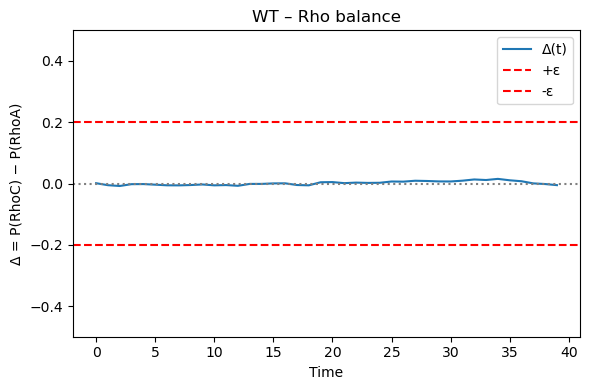

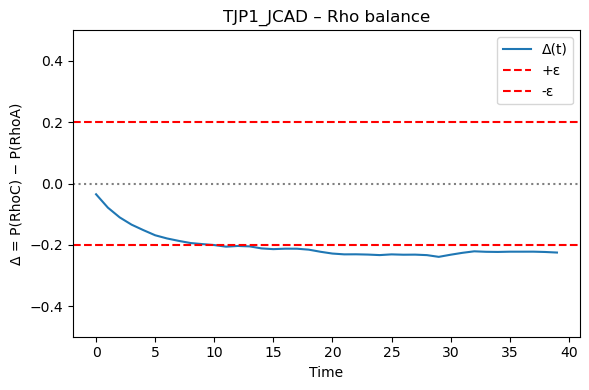

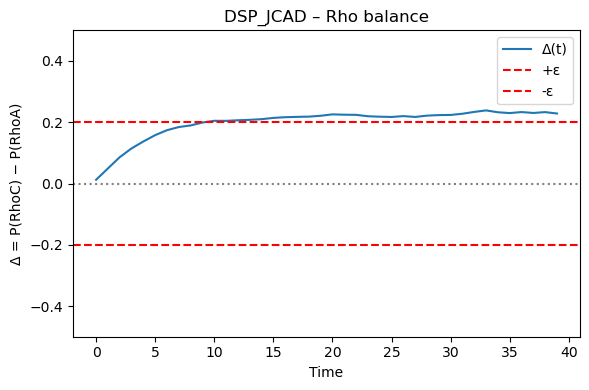

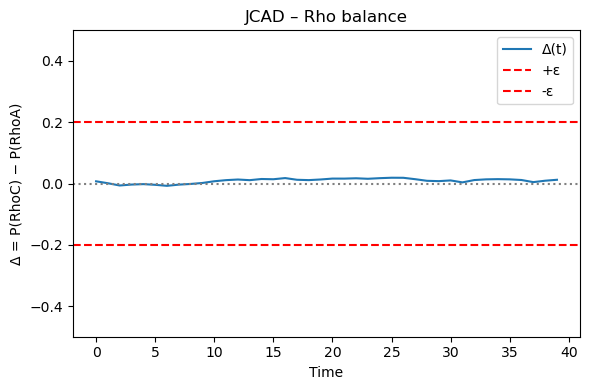

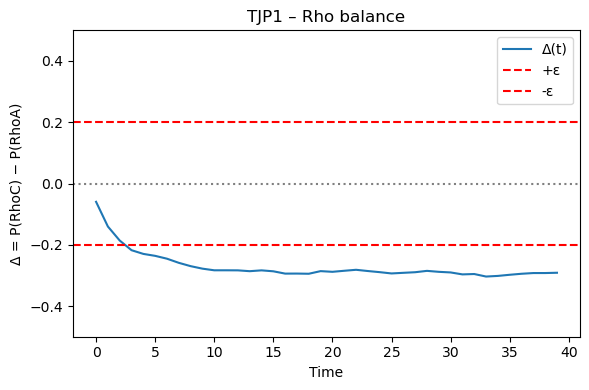

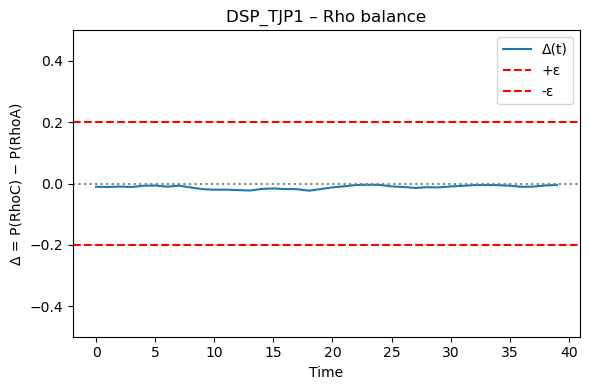

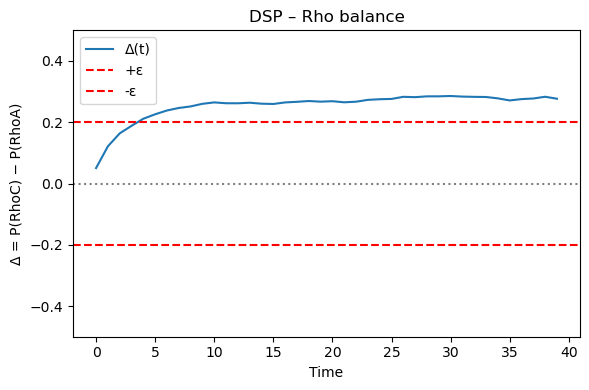

In [91]:
for name, df in perbs_dict.items(): 
    plot_rhos(name, df, True, fig_time_dir, False)
    plot_delta(name, df, 0.2, True, fig_time_dir, True)

In [77]:
wt = perbs_dict['DSP_JCAD']

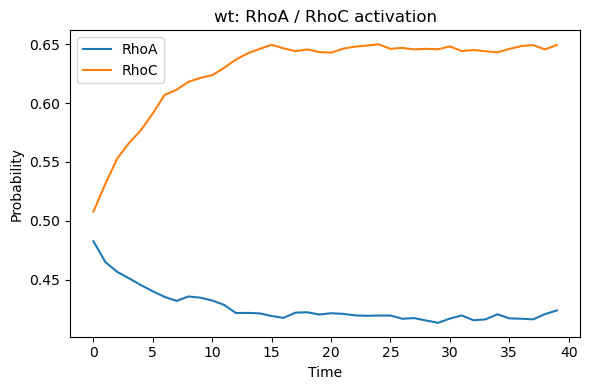

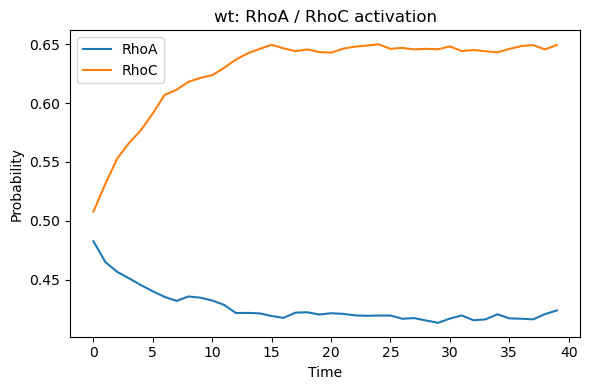

In [78]:
plot_rhos('wt', wt)

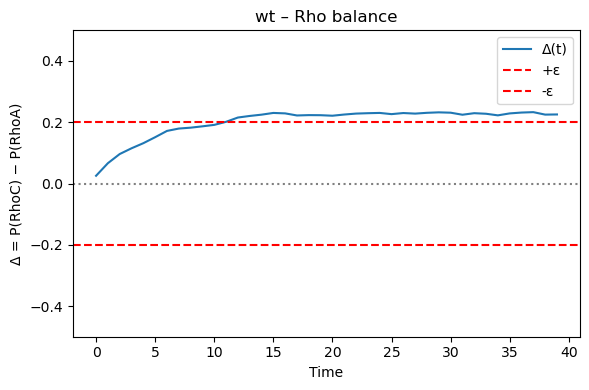

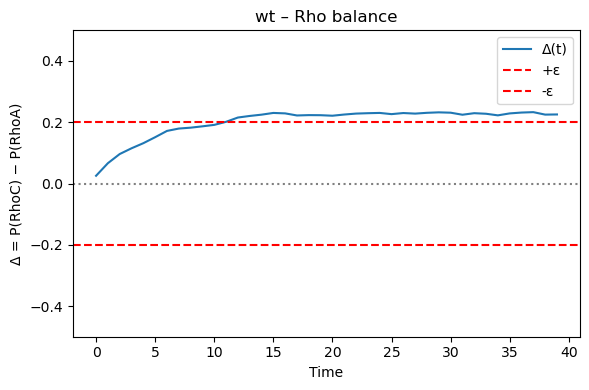

In [79]:
plot_delta('wt', wt, 0.2)

### Steady State Plotting

In [135]:
def plot_full_ss(df, eps=0.25, save=False, outdir=None, show=True):
    fig, ax = plt.subplots(figsize=(6,4))

    df["delta"].plot(kind="bar", ax=ax)

    ax.axhline(eps, linestyle="--", label="+ε", color='red')
    ax.axhline(-eps, linestyle="--", label="-ε", color='red')
    ax.axhline(0, linestyle=":", color='grey')

    ax.set_ylabel("Steady-state Δ")
    ax.set_title("Steady-state Rho balance across perturbations")
    ax.legend()

    plt.tight_layout()
    plt.show()

    if save and outdir is not None:
        outpath = outdir / f"{name}_ss_balance.png"
        fig.savefig(outpath, dpi=300)

    if show: 
        plt.show()

    plt.close(fig)

In [142]:
ss_dict = {}
for file_path in ss_dir.iterdir(): 
    name = file_path.stem.replace("steady_state_", "")
    df = pd.read_csv(file_path, index_col=[0])
    ss_dict[name] = df


pheno_df = ss_dict['phenotype']
balance_df = ss_dict['balance']
pheno_df_long = df.melt(id_vars="scenario", 
                  value_vars=["Failed", "Hyper", "Normal"], 
                  var_name="phenotype", 
                  value_name="value")
pheno_df_final = pheno_df_long[pheno_df_long["value"] == 1].drop(columns="value").reset_index(drop=True)

merged = pheno_df_final.merge(
    balance_df[['scenario', 'delta']],
    on="scenario",
    how="left"
)
merged

merged_2 = merged.set_index('scenario')

merged_2.copy().drop(index=['DSP_TJP1'])


,phenotype,delta
scenario,,
TJP1,Failed,-0.291226
DSP,Hyper,0.276774
WT,Normal,-0.005297
JCAD,Normal,0.012234
DSP_JCAD,Normal,0.228513
TJP1_JCAD,Normal,-0.225271


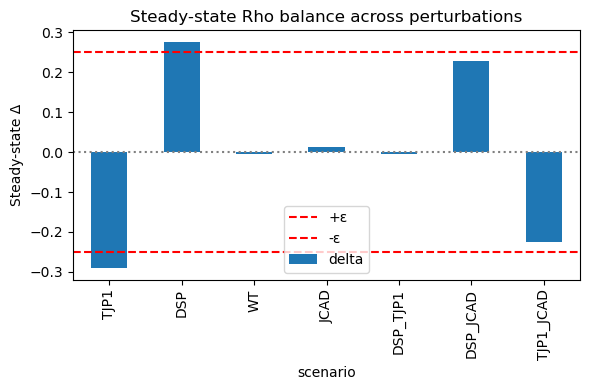

In [143]:

plot_full_ss(merged_2)